### Excel Formula Parser: Converts Excel Formula to Abstract Syntax Tree (AST)



In [215]:
import re

class Cell:
  def __init__(self, col, row):
    self.col = col
    self.row = row
  def __repr__(self):
    return "Cell[%s%d]" % (self.col, self.row)

class CellRange:
  def __init__(self, start, end):
    self.start = start
    self.end   = end
  def __repr__(self):
    return "Range[%s][%s]" % (self.start, self.end)

class Name:
  def __init__(self, name):
    self.name = name
  def __repr__(self):
    return "Name[%s]" % self.name

class Function:
  def __init__(self, func_name, arguments):
    self.func_name = func_name
    self.arguments    = arguments
  def __repr__(self):
    return "Func[%s][%d][%s]" % (self.func_name, len(self.arguments), ", ".join(map(str, self.arguments)))

class Number:
  def __init__(self, value):
    self.value = value
  def __repr__(self):
    return "Num[%f]" % self.value

class Logical:
  def __init__(self, value):
    self.value = value
  def __repr__(self):
    return "Bool[%s]" % self.value

class Binary:
  def __init__(self, left, op, right):
    self.left = left
    self.op = op
    self.right = right
  def __repr__(self):
    return "Binary[%s][%s][%s]" % (self.op, self.left, self.right)

class Unary:
  def __init__(self, op, expr):
    self.op = op
    self.expr = expr
  def __repr__(self):
    return "Unary[%s][%s]" % (self.op, self.expr)

def _tokenize(code):
  return code.replace(":", " : ").replace(",", " , ").replace("(", " ( ").replace(")", " ) ")\
             .replace("*", " * ").replace("+", " + ").replace("/", " / ").replace("-", " - ")\
             .replace("%", " % ").replace("^", " ^ ").replace("=", " = ").replace("<", " < ")\
             .replace("e - ", "e-").replace("e + ", "e+")\
             .replace("> =", " >= ").replace("< =", " <= ").replace("< >", " <> ")\
             .split()


class FormulaParseError(Exception): pass

def _parse(tokens):

  def _parse_logical():
    if tokens[0].lower() == "true":
      tokens.pop(0)
      return Logical(True)
    elif tokens[0].lower() == "false":
      tokens.pop(0)
      return Logical(False)

  def _parse_number():
    try:
      number = int(tokens[0])
      tokens.pop(0)
      return Number(number)
    except ValueError:
      try:
        number = float(tokens[0])
        tokens.pop(0)
        return Number(number)
      except:
        return None

  def _parse_cell():
    # https://support.microsoft.com/en-us/office/overview-of-formulas-in-excel-ecfdc708-9162-49e8-b993-c311f47ca173
    cell_regex = '^([a-zA-Z]+)([0-9]+)$'
    matches = re.match(cell_regex, tokens[0])
    if matches is None:
      return None
    col = matches.group(1).upper()
    if len(col) > 3 or col > 'XFD':
      return None
    row = int(matches.group(2))
    if row > 1048576 or row == 0:
      return None
    return Cell(col, row)

  def _parse_cell_or_range():
    cell1 = _parse_cell()
    if cell1 is None:
      return None
    tokens.pop(0)
    if len(tokens) == 0 or tokens[0] != ':':
      return cell1
    tokens.pop(0)
    if len(tokens) == 0:
      raise FormulaParseError("Unexpected end-of-formula after colon")
    cell2 = _parse_cell()
    if cell2 is None:
      raise FormulaParseError("Expected cell after colon, found " + tokens[0])
    tokens.pop(0)
    return CellRange(cell1, cell2)

  def _parse_name_or_func():
    # https://support.microsoft.com/en-us/office/names-in-formulas-fc2935f9-115d-4bef-a370-3aa8bb4c91f1
    name_is_ok = re.match('^[a-zA-Z_][a-zA-Z0-9_.]+$', tokens[0])
    if name_is_ok is None:
      return None
    name = tokens.pop(0).upper()
    if len(tokens) == 0 or tokens[0] != "(":
      return Name(name)
    tokens.pop(0)
    arguments = []
    while True:
      if len(tokens) == 0:
        raise FormulaParseError("Unexpected end-of-formula while parsing arguments of " + name)
      arg = _parse_expr()
      if arg is None:
        return None
      arguments.append(arg)
      if len(tokens) == 0:
        raise FormulaParseError("Unexpected end-of-formula while parsing arguments of " + name)
      next = tokens.pop(0)
      if next == ")":
        break
      elif next == ",":
        continue
      else:
        raise FormulaParseError("Expected closed parenthesis or comma after argument of function " + name)
    return Function(name, arguments)

  def _parse_unary():
    if tokens[0] in ["+", "-"]:
      op = tokens.pop(0)
      if len(tokens) == 0:
        raise FormulaParseError("Unexpected end-of-formula after unary operator " + op)
      return Unary(op, _parse_expr())

  def _parse_op():
    if tokens[0] in ["+", "-", "*", "/", "%", "^", "=", "<>", "<", ">", "<=", ">="]:
      return tokens.pop(0)
    raise FormulaParseError("Unknown operator " + tokens.pop(0))

  def _parse_basic_expr():
    logical = _parse_logical()
    if logical is not None:
      return logical
    number = _parse_number()
    if number is not None:
      return number
    cell_or_range = _parse_cell_or_range()
    if cell_or_range is not None:
      return cell_or_range
    func_or_name = _parse_name_or_func()
    if func_or_name is not None:
      return func_or_name
    if tokens[0] == "(":
      tokens.pop(0)
      expr = _parse_expr()
      if len(tokens) == 0 or tokens[0] != ")":
        raise FormulaParseError("Closed parenthesis expected")
      return expr
    if tokens[0] == "+" or tokens[0] == "-":
      op = tokens.pop(0)
      if len(tokens) == 0:
        raise FormulaParseError("Unexpected end-of-formula after unary operator " + op)
      expr = _parse_basic_expr()
      return Unary(op, expr)

  def _parse_expr():
    if len(tokens) == 0:
      raise FormulaParseError("Expression cannot be empty")

    arithmetic = []

    while True:
      basic = _parse_basic_expr()
      if basic is not None:
        arithmetic.append(basic)
      else:
        raise FormulaParseError("Expected a number, a boolean, a cell, a range, or a function call")

      if len(tokens) == 0 or tokens[0] == "," or tokens[0] == ")":
        break

      arithmetic.append(_parse_op())

    # resolve precedence according to
    # https://support.microsoft.com/en-us/office/calculation-operators-and-precedence
    # -in-excel-48be406d-4975-4d31-b2b8-7af9e0e2878a

    level = { "%": 0, "^": 1, "*": 2, "/": 2, "+": 3, "-": 3, "=": 4, "<": 4, ">": 4,
              "<=": 4, ">=": 4, "<>": 4 }

    # Ugh, I don't want to think about this...
    while len(arithmetic) != 1:
      min_i = 1
      for i in range(1, len(arithmetic), 2):
        if level[arithmetic[i]] < level[arithmetic[min_i]]:
          min_i = i
      arithmetic = arithmetic[0:min_i-1] \
                   + [Binary(arithmetic[min_i-1], arithmetic[min_i], arithmetic[min_i+1])] \
                   + arithmetic[min_i+2:]

    return arithmetic[0]

  expr = _parse_expr()

  if len(tokens) > 0:
    raise FormulaParseError("Multiple formulas provided")

  return expr

def parse(code):
  tokens = _tokenize(code)
  return _parse(tokens)

### String Function: Converts Abstract Syntax Tree (AST) back to String

The ast_to_string function is designed to convert an Abstract Syntax Tree (AST) back into a string representation of an Excel formula. It takes an AST node and optionally a parent node as input, and returns the string representation of that node.

In [216]:
# Function that converts Abstract Syntax Tree (AST) back to String.
def ast_to_string(node, parent=None):

    if isinstance(node, Function):
        # If node is a Function, iterate through all arguments and convert them to a string. Joins these strings with commas.
        # The function name is then combined with these arguments enclosed in parentheses.
        args_string = ', '.join(ast_to_string(arg, node) for arg in node.arguments)
        return f"{node.func_name}({args_string})"

    elif isinstance(node, CellRange):
        # If the node is a CellRange, it converts the start and end cells of the range to their string representations and joins them with a colon like "A1:B2".
        return f"{ast_to_string(node.start, node)}:{ast_to_string(node.end, node)}"

    elif isinstance(node, Cell):
        # If the node is a Cell, it converts the cell to its string representation like "A1".
        return f"{node.col}{node.row}"

    elif isinstance(node, Name):
        # If the node is a Name/Identifier (like a named range or variable), it converts the Name/Identifier to a string.
        return node.name

    elif isinstance(node, Number):
        # If the node is a Number, it converts the number to a string.
        return str(node.value)

    elif isinstance(node, Logical):
        # If the node is a Logical (boolean value), it converts it to a string ("TRUE" or "FALSE").
        return "TRUE" if node.value else "FALSE"

    elif isinstance(node, Binary):
        # If the node is a Binary operation (like addition, subtraction), it converts both the left and right operands to strings and joins them with the operator (e.g., "A1 + B1").
        # If this binary operation is not the top-level operation (has a parent), it encloses the operation in parentheses.
        left = ast_to_string(node.left, node)
        right = ast_to_string(node.right, node)
        operation = f"{left}{node.op}{right}"
        if parent is None:
            return operation
        else:
            return f"({operation})"

    elif isinstance(node, Unary):
        # If the node is a Unary operation, it converts the operand to a string and precedes it with the unary operator (e.g., "-A1").
        return f"{node.op}{ast_to_string(node.expr, node)}"

    else:
        # If the node type is not recognized, it raises an error.
        raise ValueError(f"Unsupported AST node type: {type(node)}")

### Define Colour Map & Import Libraries

In [217]:
# Install graphviz
!pip install graphviz

In [218]:
# Import necessary libraries
from IPython.display import display, HTML
from PIL import Image
from graphviz import Digraph
import matplotlib.pyplot as plt

In [219]:
# Define color map with HTML color names
html_color_map = {
    'Cell': 'red',
    'CellRange': 'green',
    'Name': 'blue',
    'Function': 'orange',
    'Number': 'lightblue',
    'Logical': 'violet',
    'Binary': 'grey',
    'Unary': 'pink'
}

### Colorize AST Function & Colorize String Function

In [220]:
def colorize_ast(node):
    # Get the class name of the node to determine its type
    node_type = type(node).__name__

    # For simpler node types (Cell, Name, Number, Logical), colorize directly
    if node_type in ['Cell', 'Name', 'Number', 'Logical']:
        # Obtain the color for the node type, default to black if not found
        color = html_color_map.get(node_type, 'black')
        # Return the node's string representation wrapped in a colored HTML span
        return f'<span style="color: {color}">{node}</span>'

    # For CellRange type, colorize the start and end separately
    elif node_type == 'CellRange':
        # Colorize the start and end nodes of the CellRange
        start_color = colorize_ast(node.start)
        end_color = colorize_ast(node.end)
        # Return the CellRange representation with start and end colors
        return f'<span style="color: {html_color_map.get("CellRange", "black")}">CellRange[{start_color}][{end_color}]</span>'

    # For complex types like Function, Binary, Unary, recursively apply colorization
    elif node_type in ['Function', 'Binary', 'Unary']:
        parts = []
        # Iterate over each attribute of the node and apply colorization
        for attr in node.__dict__.values():
            # If the attribute is a list, apply colorization to each item
            if isinstance(attr, list):
                part_colors = [colorize_ast(item) for item in attr]
                parts.append(", ".join(part_colors))
            else:
                # Apply colorization to single-value attributes
                parts.append(colorize_ast(attr))
        # Get the color for the current node type
        color = html_color_map.get(node_type, 'black')
        # Return the node's type and colored attributes
        return f'<span style="color: {color}">{node_type}[{"], [".join(parts)}]</span>'

    else:
        # Return the default string representation for unhandled types
        return str(node)

In [221]:
def colorize_string(node, parent=None):
    def colored_span(text, color):
        # Function to wrap text in an HTML span tag with a specified color
        # Used for rendering colored text in the final output
        return f'<span style="color: {color};">{text}</span>'

    # Handle different types of AST nodes and colorize them accordingly
    if isinstance(node, Function):
        # Colorize and concatenate arguments of a function
        args_string = ', '.join(colorize_string(arg, node) for arg in node.arguments)
        # Return the function name and arguments as a colored string
        return colored_span(f"{node.func_name}({args_string})", html_color_map['Function'])

    elif isinstance(node, CellRange):
        # Colorize the start and end of a cell range
        start = colorize_string(node.start, node)
        end = colorize_string(node.end, node)
        # Return the cell range as a colored string
        return colored_span(f"{start}:{end}", html_color_map['CellRange'])

    elif isinstance(node, Cell):
        # Return the cell identifier (e.g., A1, B2) as a colored string
        return colored_span(f"{node.col}{node.row}", html_color_map['Cell'])

    elif isinstance(node, Name):
        # Return a named range or variable as a colored string
        return colored_span(node.name, html_color_map['Name'])

    elif isinstance(node, Number):
        # Return a number as a colored string
        return colored_span(str(node.value), html_color_map['Number'])

    elif isinstance(node, Logical):
        # Return a logical value (TRUE/FALSE) as a colored string
        return colored_span("TRUE" if node.value else "FALSE", html_color_map['Logical'])

    elif isinstance(node, Binary):
        # Colorize the left and right parts of a binary operation
        left = colorize_string(node.left, node)
        right = colorize_string(node.right, node)
        operation = f"{left} {node.op} {right}"
        # Enclose binary operations in parentheses if they are not the root node
        if parent is None:
            return colored_span(operation, html_color_map['Binary'])
        else:
            return f"({colored_span(operation, html_color_map['Binary'])})"

    elif isinstance(node, Unary):
        # Colorize unary operations (e.g., -5, +3)
        return colored_span(f"{node.op}{colorize_string(node.expr, node)}", html_color_map['Unary'])

    else:
        # Raise an error if an unsupported AST node type is encountered
        raise ValueError(f"Unsupported AST node type: {type(node)}")

### Image Visualization: Visualize Abstract Syntax Tree (AST) and String with Colours

In [222]:
# Function to display the images
def display_image(image_path):
    img = Image.open(image_path)
    plt.figure(figsize=(30, 20))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [223]:
# Define the get_id function and its counter attribute
def get_id():
    get_id.counter += 1
    return str(get_id.counter)
get_id.counter = 0  # Initialize the counter

In [224]:
def visualize_ast(node, graph, parent=None):

    # Get the name of the node's class (e.g., 'Function', 'Binary', etc.)
    node_type = type(node).__name__

    # Lookup the color for the node type from html_color_map, default to 'black' if not found
    color = html_color_map.get(node_type, 'black')

    # Create a label for the node combining its type and string representation
    label = node_type + " (" + str(node) + ")"

    # If there's no parent, this is the root node
    if parent is None:
        root = str(id(node)) # Create a unique identifier for the root node
        graph.node(root, label, style='filled', fillcolor=color) # Add the root node to the graph with the specified label and color

    # If there's a parent, this is a child node. Create unique identifiers for the parent and child nodes
    else:
        root = str(id(parent))
        child = str(id(node))
        graph.node(child, label, style='filled', fillcolor=color) # Add the child node to the graph with the specified label and color
        graph.edge(root, child) # Connect the child node to its parent with an edge

    # Recursively process the children of the node, depending on its type
    # If the node is a 'Function', visualize each of its arguments
    if isinstance(node, Function):
        for arg in node.arguments:
            visualize_ast(arg, graph, node)
    # If the node is a 'Binary' operation, visualize its left and right children
    elif isinstance(node, Binary):
        visualize_ast(node.left, graph, node)
        visualize_ast(node.right, graph, node)
    # If the node is a 'Unary' operation, visualize its single operand
    elif isinstance(node, Unary):
        visualize_ast(node.expr, graph, node)
    # If the node represents a 'CellRange', visualize its start and end points
    elif isinstance(node, CellRange):
        visualize_ast(node.start, graph, node)
        visualize_ast(node.end, graph, node)

In [225]:
# Function to create a  graph visualization of the AST representation
def create_ast_diagram(parsed_formula):
    graph = Digraph(comment='AST for ' + formula)
    visualize_ast(parsed_formula, graph)
    output_filename = '/content/output1'
    graph.render(output_filename, view=False, format='png')
    return output_filename + '.png'

In [226]:
def visualize_string(node, graph, parent_id=None):

    # Generate a unique identifier for the current node
    node_id = get_id()

    # Convert the node to its string representation using ast_to_string function
    node_label = ast_to_string(node)

    # Add the node to the graph with the string representation as the label
    graph.node(node_id, label=node_label)

    # If this node is not the root, add an edge from the parent
    if parent_id is not None:
        graph.edge(parent_id, node_id)

    # Recursively call visualize_string for children nodes
    # Recursively process and visualize children of the node, depending on its type
    # If the node is a 'Function', call visualize_string for each of its arguments
    if isinstance(node, Function):
        for arg in node.arguments:
            visualize_string(arg, graph, node_id)

    # If the node is a 'Binary' operation, call visualize_string for its left and right parts
    elif isinstance(node, Binary):
        visualize_string(node.left, graph, node_id)
        visualize_string(node.right, graph, node_id)

In [227]:
# Function to create a black & grey graph visualization of the string representation
def create_string_diagram(parsed_formula):
    graph = Digraph(comment='Black & Grey String visualization for formula')
    visualize_string(parsed_formula, graph)
    output_filename = '/content/output2'
    graph.render(output_filename, view=False, format='png')
    return output_filename + '.png'

In [228]:
def visualize_string_color(node, graph, parent=None):
    # Retrieve the class name of the node to determine its type (e.g., Function, Binary, etc.)
    node_type = type(node).__name__

    # Look up the color associated with this node type in the html_color_map; default to black
    color = html_color_map.get(node_type, 'black')

    # Generate the label for the node using its string representation
    node_label = ast_to_string(node)

    # Create a graph node. If this is the root node (no parent), use its own id as the root.
    if parent is None:
        root = str(id(node))
        graph.node(root, node_label, style='filled', fillcolor=color)
    else:
        # If this node has a parent, create a node and an edge from the parent to this node.
        root = str(id(parent))
        child = str(id(node))
        graph.node(child, node_label, style='filled', fillcolor=color)
        graph.edge(root, child)

    # Depending on the node type, recursively process its children
    # For a Function node, visualize each of its arguments
    if isinstance(node, Function):
        for arg in node.arguments:
            visualize_string_color(arg, graph, node)
    # For a Binary node, visualize its left and right children
    elif isinstance(node, Binary):
        visualize_string_color(node.left, graph, node)
        visualize_string_color(node.right, graph, node)
    # For a Unary node, visualize its single operand
    elif isinstance(node, Unary):
        visualize_string_color(node.expr, graph, node)
    # For a CellRange node, visualize its start and end points
    elif isinstance(node, CellRange):
        visualize_string_color(node.start, graph, node)
        visualize_string_color(node.end, graph, node)

In [229]:
# Function to create a graph visualization of the colorized string representation
def create_string_color_diagram(parsed_formula):
    graph = Digraph(comment='String Color visualization for formula')
    visualize_string_color(parsed_formula, graph)
    output_filename = '/content/output3'
    graph.render(output_filename, view=False, format='png')
    return output_filename + '.png'

### Example Formula: Parsing and String Conversion

In [230]:
# Choose an example formula to display in string format
formula = 'SUM(ABS(A1:A100)) + IF(true, INIT_VALUE, B12)*4'

In [231]:
# Print the String representation of the formula
print(formula)

SUM(ABS(A1:A100)) + IF(true, INIT_VALUE, B12)*4


In [232]:
# Convert to AST
ast = parse(formula)

In [233]:
# Print the AST representation of the formula
print(ast)

Binary[+][Func[SUM][1][Func[ABS][1][Range[Cell[A1]][Cell[A100]]]]][Binary[*][Func[IF][3][Bool[True], Name[INIT_VALUE], Cell[B12]]][Num[4.000000]]]


In [234]:
# Convert AST back to String
formula_back = ast_to_string(ast)

In [235]:
# Print the converted back string formula
print(formula_back)

SUM(ABS(A1:A100))+(IF(TRUE, INIT_VALUE, B12)*4)


### Example Visualizations

In [236]:
# Create and display the colorized ast representation
color_ast = colorize_ast(ast)
display(HTML(color_ast))

In [237]:
# Create and display the colorized string representation
color_string = colorize_string(ast)
display(HTML(color_string))

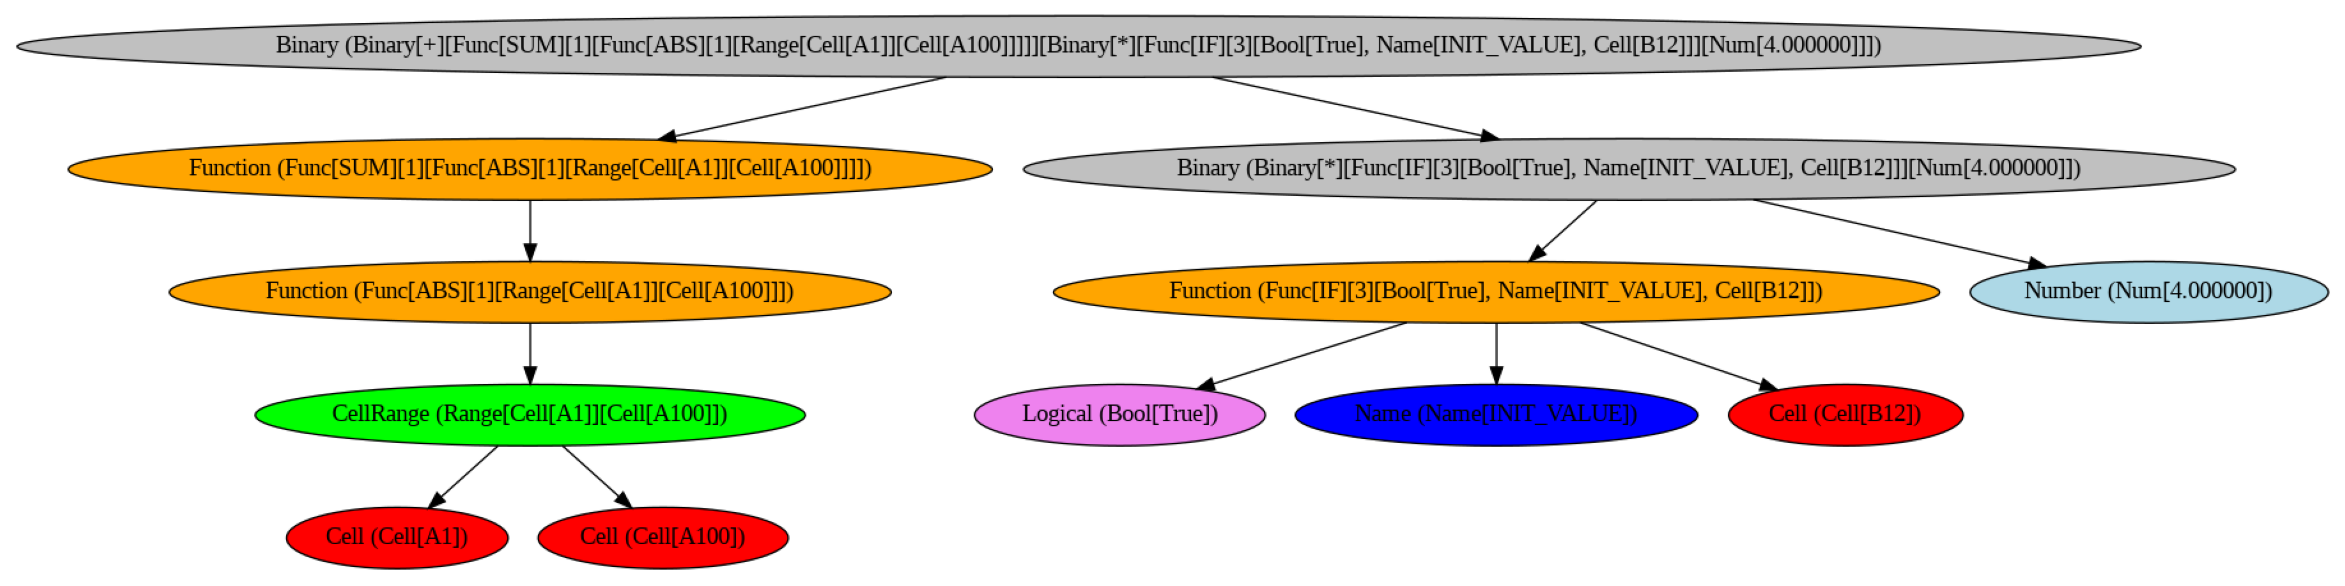

In [238]:
# Create and display the AST Diagram colorized
image_path_ast = create_ast_diagram(ast)
display_image(image_path_ast)

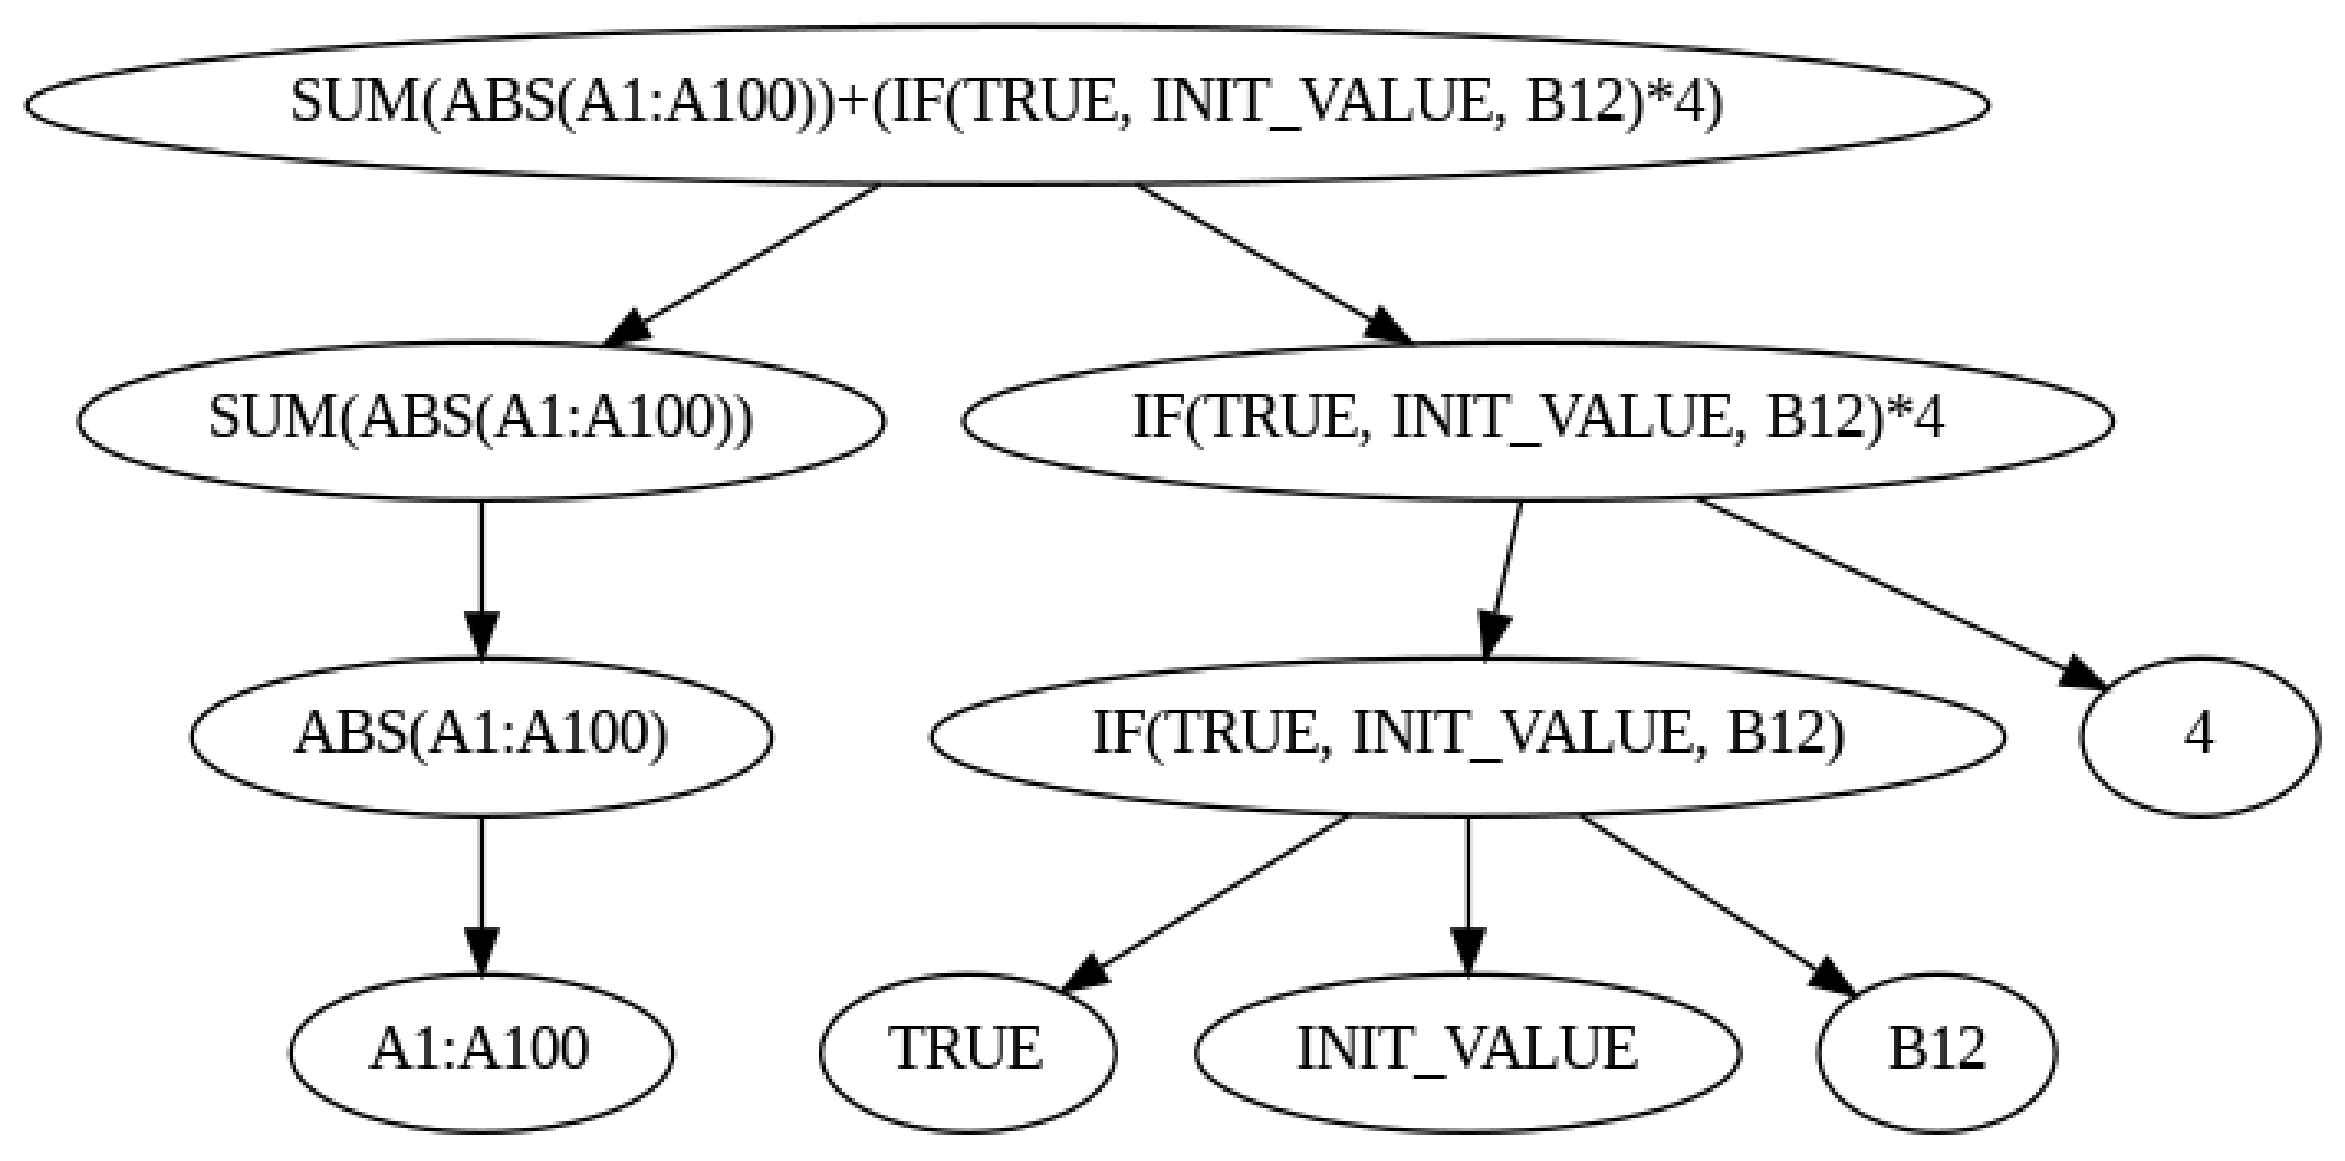

In [239]:
# Create and display the AST Diagram with the formulas in string representation
image_path_string = create_string_diagram(ast)
display_image(image_path_string)

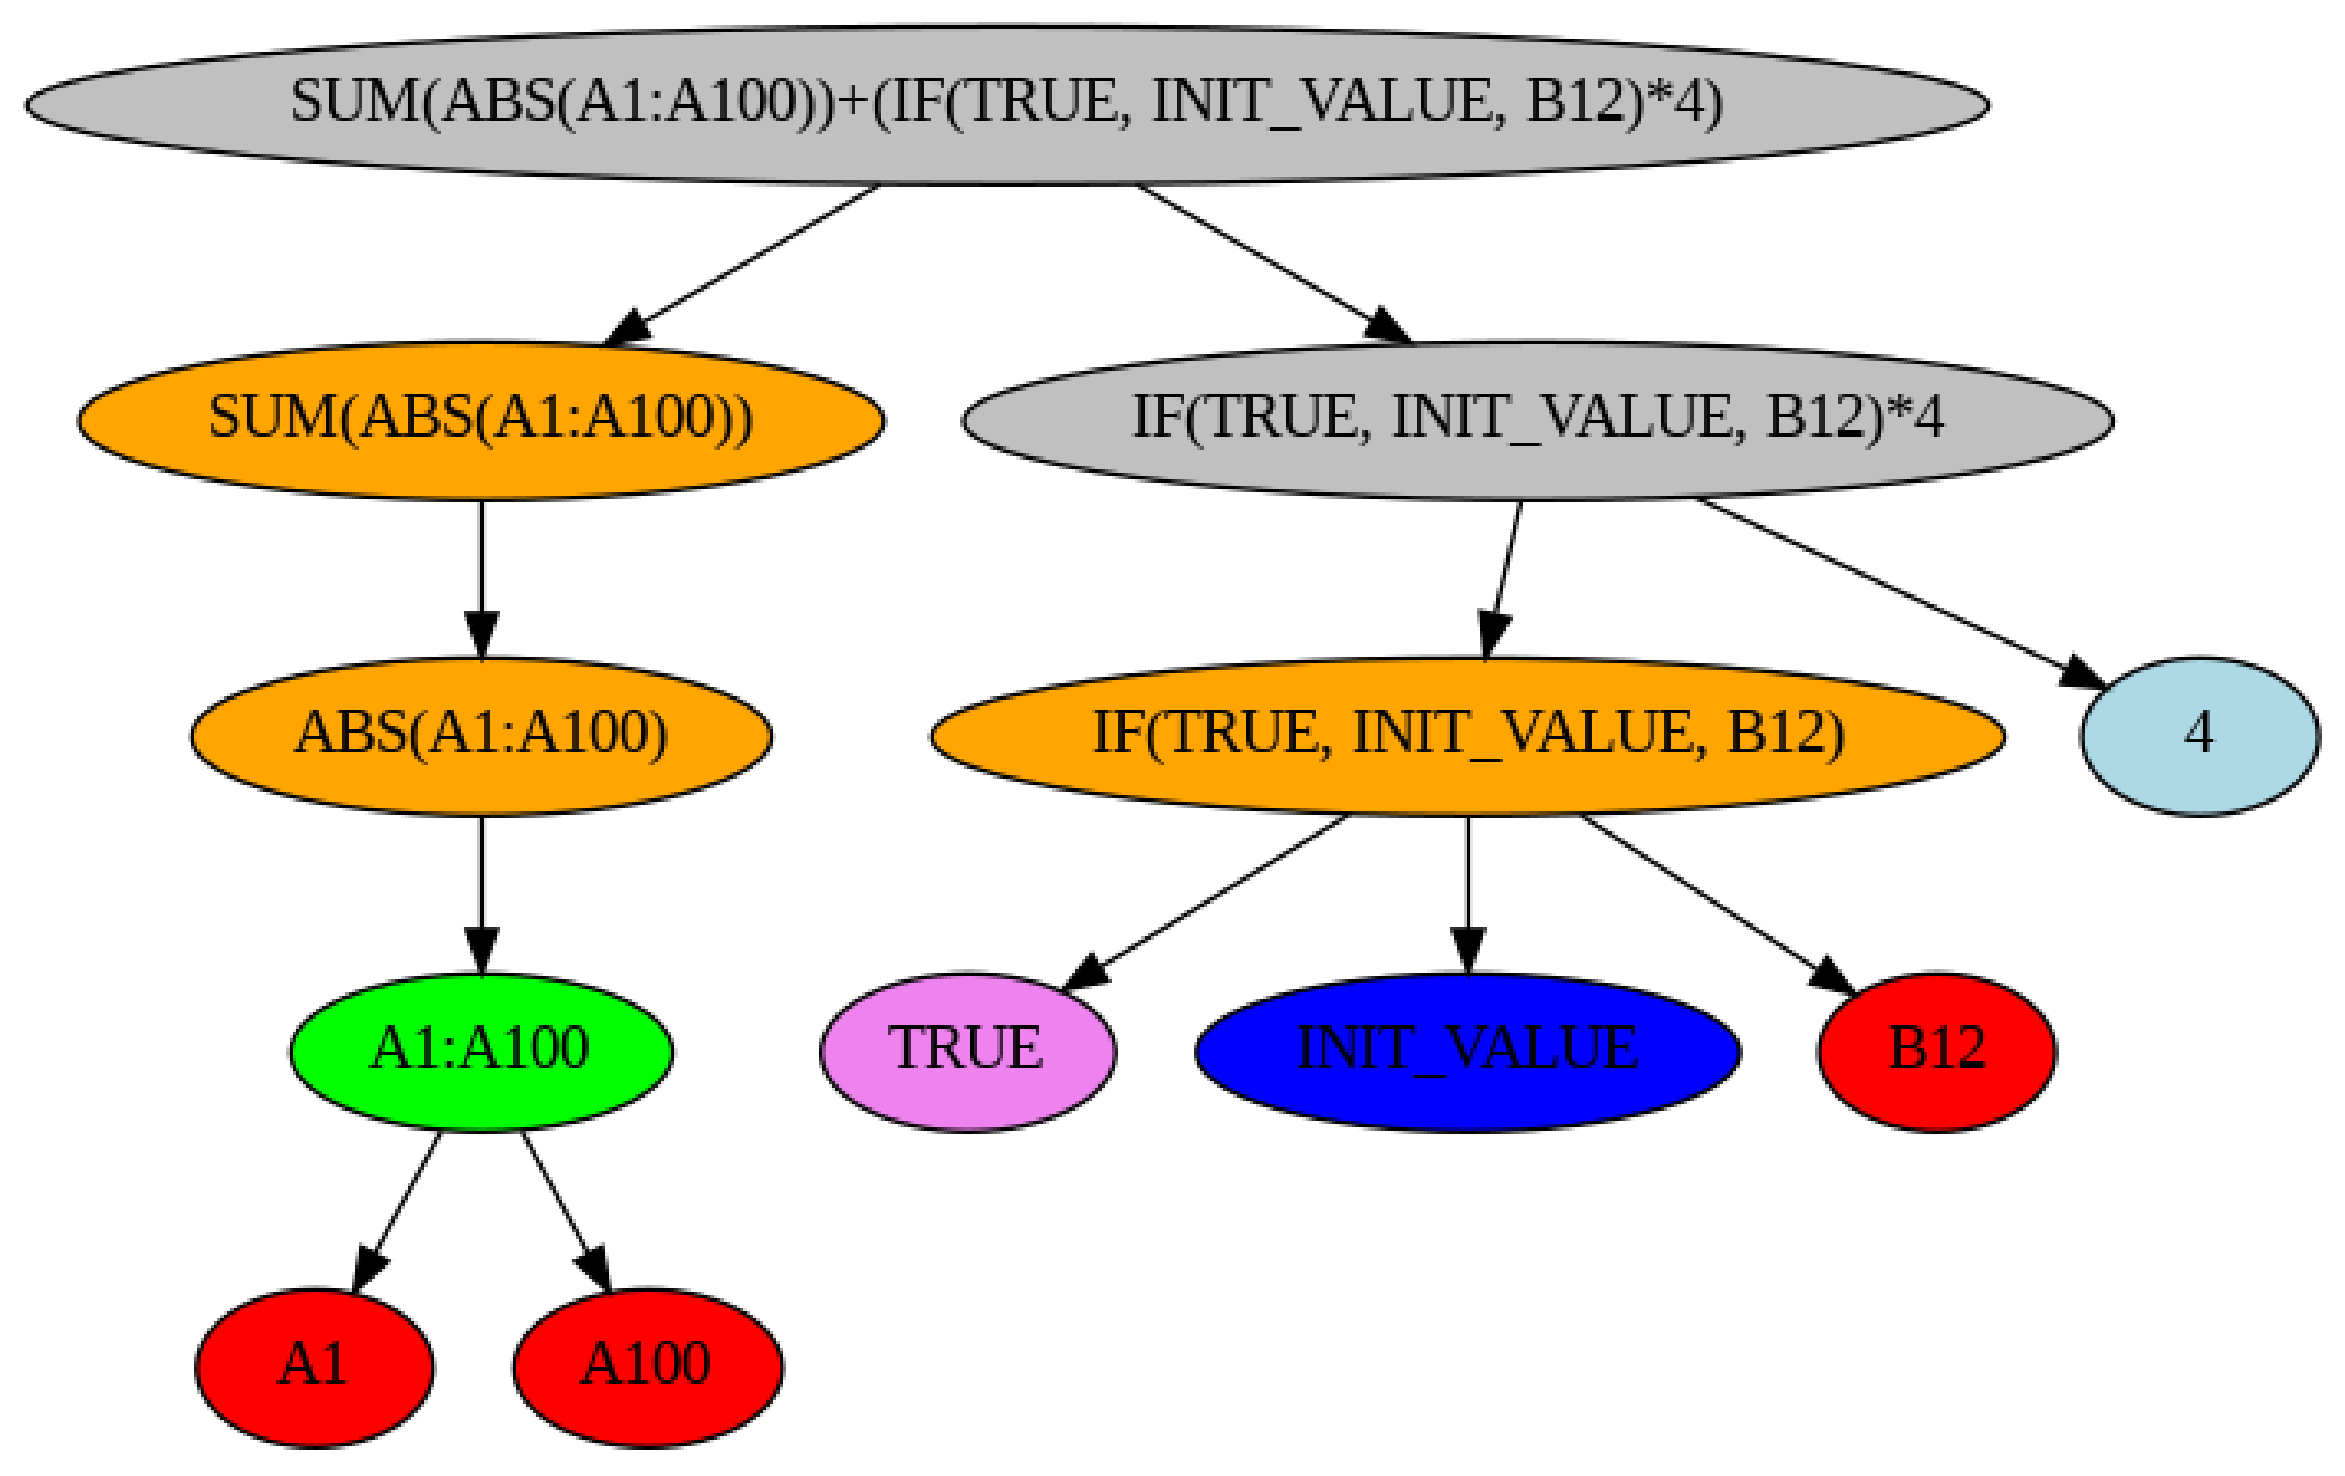

In [240]:
# Create and display the AST Diagram with the formulas in string representation and colorized
image_path_string_color = create_string_color_diagram(ast)
display_image(image_path_string_color)

gfg